In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import multinomial


## Need to add the background story to here to why to use HMMs 

In [10]:
start = 0
x = []
n = 10000
for i in range(n):
    step = np.random.choice([-1,1],p=[0.45,0.55])
    start = start + step
    x.append(start)

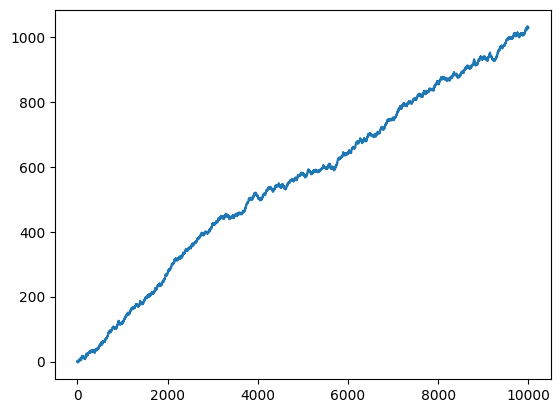

In [11]:
plt.plot(x)
# plt.xlabel('Steps',fontsize=20)
# plt.ylabel(r'$S_{n}$',fontsize=20)

In [12]:
def markov_sequence(p_init, p_transition, sequence_length):
    """
    Generate a Markov sequence based on p_init and p_transition.
    """
    if p_init is None:
        p_init = equilibrium_distribution(p_transition)
    initial_state = list(multinomial.rvs(1, p_init)).index(1)

    states = [initial_state]
    for _ in range(sequence_length - 1):
        p_tr = p_transition[states[-1]]
        new_state = list(multinomial.rvs(1, p_tr)).index(1)
        states.append(new_state)
    return states

In [14]:
p_init = np.array([0.1, 0.5, 0.4])
p_transition = np.array([0.3, 0.4, 0.3])

In [17]:
states = markov_sequence(p_init, p_transition, sequence_length=1000)
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(states)
plt.xlabel("time step")
plt.ylabel("state")
plt.yticks([0, 1, 2])
sns.despine()

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

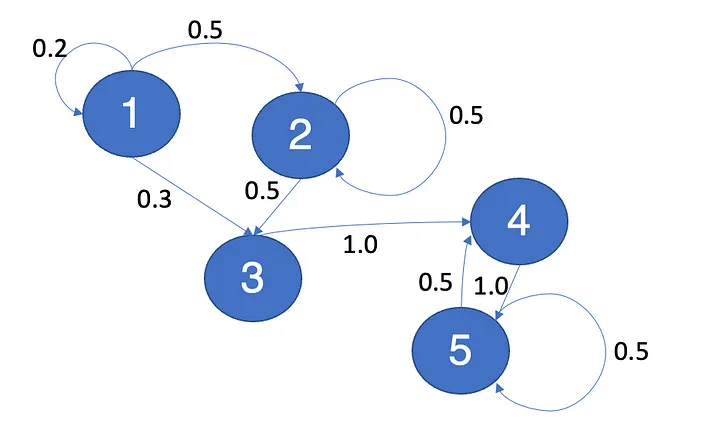